In [2]:
# 必要なモジュールと関数をインポート
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pickle
from torch.utils.data import DataLoader
from torch import nn

from utils.pann_net import PANN, EulerCell_DAB, WeightClamp
from utils.pann_train import CustomDataset, train
from utils.pann_utils import create_vpvs


In [3]:
# 日本語フォント
font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False


# DABコンバータの物理ベースニューラルネットワーク（PANN）による推論と学習

このノートブックでは、Dual Active Bridge（DAB）コンバータの物理ベースニューラルネットワーク（PANN）を用いた推論と学習を実装します。

## 目次
1. **推論部分**: DAB構造の定義とPANNによる状態変数（インダクタ電流）の推論
2. **学習部分**: 実験データを用いたPANNの学習と回路パラメータの推定

## 1. 推論部分: DAB構造とPANNによる推論

### 1.1 回路パラメータとネットワーク変数の定義

In [4]:
# 回路パラメータとネットワーク変数を定義
# n: ターン比, RL: 等価抵抗, Lr: 漏れインダクタンス
n, RL, Lr = 1, 120e-3, 63e-6

# スイッチング周波数とタイムステップの設定
Ts = 1/50e3  # スイッチング周期 (50kHz)
Tslen = 100  # 1スイッチング周期あたりのタイムステップ数
dt = Ts/Tslen  # タイムステップ

# DAB用のオイラーセルを定義
dab_Euler_cell = torch.jit.script(EulerCell_DAB(dt, Lr, RL, n))

# DAB用のPANNを定義
pann_dab = torch.jit.script(PANN(dab_Euler_cell))
print(pann_dab)

RecursiveScriptModule(
  original_name=PANN
  (cell): RecursiveScriptModule(original_name=EulerCell_DAB)
)


### 1.2 電圧波形の生成と可視化

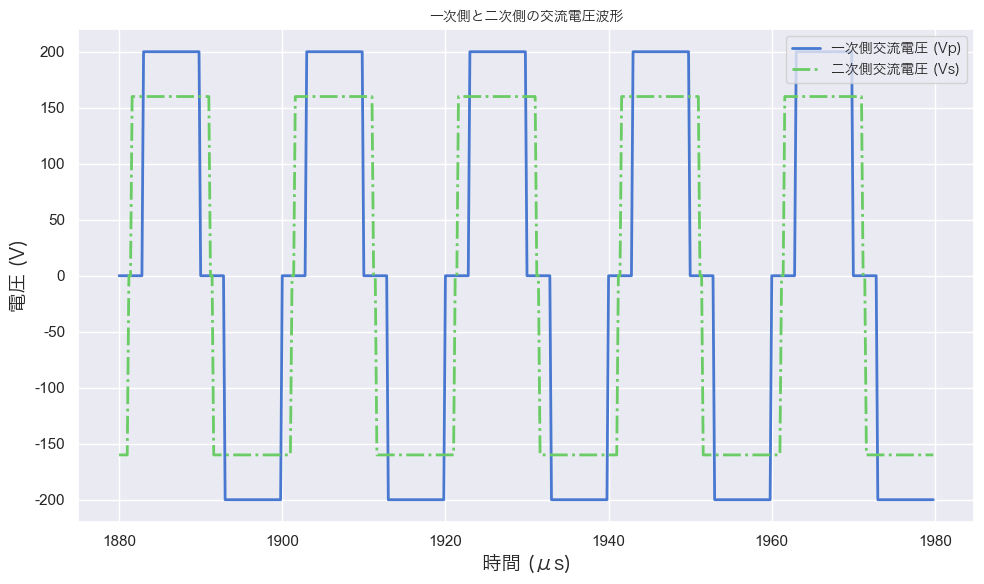

In [5]:
# 変調パラメータの設定
D0, D1, D2 = 0.1, 0.7, 0.95
Vin, Vref = 200, 160  # 入力電圧と参照電圧

# シミュレーション時間の設定（スイッチング周期の100倍を考慮）
Tsim = 100 * Ts

# 変調パラメータのセットから電圧波形（vpとvs）を生成
vp, vs = create_vpvs(
    D0,
    D1,
    D2,
    Vin,
    Vref,
    Tslen,
    dt,
    Tsim,
    Ts,
    D1_cycle=0.5,
    D2_cycle=0.5,
)

# 時間軸の作成
t = np.arange(0, len(vp) * dt, dt)

# 交流電圧波形（vpとvs）をプロット
sns.set(style="darkgrid")  # コントラストのためにダークグリッドの背景を使用

# 図と軸を作成
plt.figure(figsize=(10, 6))

# Seabornスタイルの強化で波形をプロット
plt.plot(
    t[-5 * Tslen :] * 1e6,
    vp[-5 * Tslen :],
    label="一次側交流電圧 (Vp)",
    color=sns.color_palette("muted")[0],
    linestyle="-",
    linewidth=2,
)
plt.plot(
    t[-5 * Tslen :] * 1e6,
    vs[-5 * Tslen :],
    label="二次側交流電圧 (Vs)",
    color=sns.color_palette("muted")[2],
    linestyle="-.",
    linewidth=2,
)

# タイトルとラベルを追加
plt.title(
    "一次側と二次側の交流電圧波形", fontsize=18, weight="bold", fontproperties=font_prop
)
plt.xlabel("時間 (μs)", fontsize=14, fontproperties=font_prop)
plt.ylabel("電圧 (V)", fontsize=14, fontproperties=font_prop)

# 読みやすさのためのグリッドを追加（Seabornのダークグリッドの一部として既に含まれている）
plt.grid(True)

# 波形を説明する凡例を追加
plt.legend(loc="upper right", fontsize=12, prop=font_prop)

# プロットを表示
plt.tight_layout()  # より良いフィットのためにレイアウトを調整
plt.show()

### 1.3 PANNによる状態変数（インダクタ電流）の推論

In [6]:
# numpy形式で入力テンソルを構築
inputs = np.hstack([vp[:, None], vs[:, None]])[None]
print(f"入力データの形状: {inputs.shape}, 型: {type(inputs)}")  # 形状は (bs x seq_len x inp_dim) であるべき

# torchのFloatTensorに変換
inputs = torch.FloatTensor(inputs)
print(f"変換後の形状: {inputs.shape}, 型: {type(inputs)}")

# 状態変数を初期化
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim))  # 初期値は0

# PANNを使用して状態変数iLを推論
pann_dab.eval()
with torch.no_grad():
    # トレーニングではないため、計算グラフをキャプチャしない
    states = pann_dab(inputs, state0)

print(f"出力状態の形状: {states.shape}, 型: {type(states)}")

入力データの形状: (1, 9900, 2), 型: <class 'numpy.ndarray'>
変換後の形状: torch.Size([1, 9900, 2]), 型: <class 'torch.Tensor'>
出力状態の形状: torch.Size([1, 9900, 1]), 型: <class 'torch.Tensor'>


### 1.4 推論結果の可視化（電圧とインダクタ電流の波形）

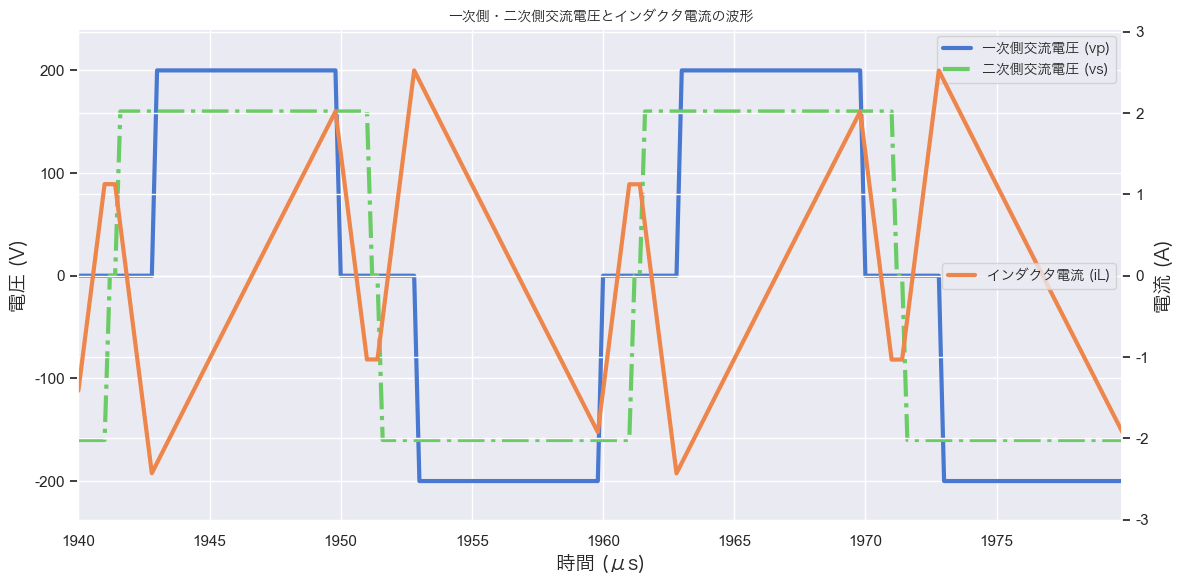

In [7]:
# 最後の2スイッチング周期分のデータを表示用に準備
if len(inputs.shape) == 3:
    t = t[-2 * Tslen :] * 1e6
    inputs = inputs[0, -2 * Tslen :]
    states = states[0, -2 * Tslen :]

# データをnumpy配列に変換
t, inputs, states = np.array(t), inputs.numpy(), states.numpy()
vp, vs, iL = inputs[:, 0], inputs[:, 1], states[:, 0]

# Seabornスタイルの設定
sns.set(style="darkgrid")

# 図とサブプロットを作成（vp、vsとiLを同じプロットに表示）
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax2 = ax1.twinx()

# 両方のプロットの制限を設定
ax1.set_xlim(t.min(), t.max())
ax1.set_ylim(-inputs.max() * 1.2, inputs.max() * 1.2)
ax2.set_ylim(-states.max() * 1.2, states.max() * 1.2)

# ラベルとタイトル
ax1.set_title(
    "一次側・二次側交流電圧とインダクタ電流の波形",
    fontsize=18,
    weight="bold",
    fontproperties=font_prop,
)
ax1.set_xlabel("時間 (μs)", fontsize=14, fontproperties=font_prop)
ax1.set_ylabel("電圧 (V)", fontsize=14, fontproperties=font_prop)
ax2.set_xlabel("時間 (μs)", fontsize=14, fontproperties=font_prop)
ax2.set_ylabel("電流 (A)", fontsize=14, fontproperties=font_prop)

# 両方のプロット用の線を初期化
(line1_1,) = ax1.plot(
    t,
    vp,
    lw=3,
    label="一次側交流電圧 (vp)",
    color=sns.color_palette("muted")[0],
    linestyle="-",
)
(line1_2,) = ax1.plot(
    t,
    vs,
    lw=3,
    label="二次側交流電圧 (vs)",
    color=sns.color_palette("muted")[2],
    linestyle="-.",
)
(line2_1,) = ax2.plot(
    t,
    iL,
    lw=3,
    label="インダクタ電流 (iL)",
    color=sns.color_palette("muted")[1],
    linestyle="-",
)

# グリッドと凡例を追加
ax1.grid(True)
ax2.grid(True)
ax1.legend(loc="upper right", fontsize=12, prop=font_prop)
ax2.legend(loc="center right", fontsize=12, prop=font_prop)

# プロットを表示
plt.tight_layout()  # より良いフィットのためにレイアウトを調整
plt.show()

## 2. 学習部分: DABのPANN学習

### 仕様（PE-GPTに記載）
- Vin = 200 V
- Vo: [160 V, 240 V]の範囲
- n = 1

### 2.1 データの読み込みと準備

In [8]:
# 波形データを読み込み
# 注意: データの一部のみが提供されています
with open("../../data/waveforms.pickle", "rb+") as f:
    inputs, states = pickle.load(f)

# トレーニング、テスト、検証データの分割比率
train_pct = 0.2  # 20%をトレーニング用
test_pct = 0.4   # 40%をテスト用
# 残り40%を検証用

# データをシャッフルして分割
np.random.seed(888)
idx = np.random.permutation(inputs.shape[0])  # インデックスをシャッフル

# 入力データの分割
train_inputs = inputs[idx[:round(train_pct*inputs.shape[0])]]
test_inputs = inputs[idx[round(train_pct*inputs.shape[0]):round((train_pct+test_pct)*inputs.shape[0])]]
val_inputs = inputs[idx[round((train_pct+test_pct)*inputs.shape[0]):]]

# 状態データの分割
train_states = states[idx[:round(train_pct*inputs.shape[0])]]
test_states = states[idx[round(train_pct*inputs.shape[0]):round((train_pct+test_pct)*inputs.shape[0])]]
val_states = states[idx[round((train_pct+test_pct)*inputs.shape[0]):]]

print(f"トレーニングデータ形状: {train_inputs.shape}, テストデータ形状: {test_inputs.shape}, 検証データ形状: {val_inputs.shape}")
print(f"トレーニング状態形状: {train_states.shape}, テスト状態形状: {test_states.shape}, 検証状態形状: {val_states.shape}")

トレーニングデータ形状: (2, 2250, 2), テストデータ形状: (5, 2250, 2), 検証データ形状: (5, 2250, 2)
トレーニング状態形状: (2, 251, 1), テスト状態形状: (5, 251, 1), 検証状態形状: (5, 251, 1)


### 2.2 PyTorchのデータローダーを準備

In [ ]:
# numpy配列をtorchテンソルに変換
train_inputs = torch.Tensor(train_inputs)
test_inputs = torch.Tensor(test_inputs)
val_inputs = torch.Tensor(val_inputs)
train_states = torch.Tensor(train_states)
test_states = torch.Tensor(test_states)
val_states = torch.Tensor(val_states)

# トレーニングプロセス用のDataLoaderを定義
# CustomDatasetは時系列データ用のカスタムデータセット
data_loader_train = DataLoader(
    dataset=CustomDataset(
        train_states[:, :-1],
        train_inputs[:, 1:],
        train_states[:, 1:],
    ),
    batch_size=40,
    shuffle=True,
    drop_last=False,
)

### 2.3 PANNモデルとオプティマイザの設定

In [ ]:
# ランダムシードを定義
np.random.seed(888)

# PANNを初期化
# 回路パラメータの初期推定値
n, RL, Lr = 1.1, 10e-3, 80e-6
Ts = 1 / 50e3
Tslen = 250
dt = Ts / Tslen

# DAB用のオイラーセルを定義
dab_Euler_cell = torch.jit.script(EulerCell_DAB(dt, Lr, RL, n))
# DAB用のPANNを定義
pann_dab = torch.jit.script(PANN(dab_Euler_cell))

# オプティマイザを定義
# 異なる回路パラメータに対して異なる学習率を設定
param_list = ["cell.Lr"]  # 漏れインダクタンス
param_list2 = ["cell.n"]  # ターン比
param_list3 = ["cell.RL"]  # 等価抵抗

# パラメータをフィルタリング
params = list(filter(lambda kv: kv[0] in param_list, pann_dab.named_parameters()))
params2 = list(filter(lambda kv: kv[0] in param_list2, pann_dab.named_parameters()))
params3 = list(filter(lambda kv: kv[0] in param_list3, pann_dab.named_parameters()))

# 異なる回路パラメータに対して異なる学習率を定義
optimizer_pann = torch.optim.Adam(
    [
        {"params": [param[1] for param in params], "lr": 2e-6},  # Lr用の学習率
        {"params": [param[1] for param in params2], "lr": 1e-1},  # n用の学習率
        {"params": [param[1] for param in params3], "lr": 5e-1},  # RL用の学習率
    ]
)

# 回路パラメータ値を制限するための重みクランパーを作成
clamper = WeightClamp(
    ["cell.Lr", "cell.RL", "cell.n"],
    [(10e-6, 200e-6), (1e-3, 5e0), (0.8, 1.2)],  # 各パラメータの範囲
)

# トレーニング損失を定義
loss_pann = nn.MSELoss()

# テストと検証データの準備
test_data = (test_inputs, test_states)
val_data = (val_inputs, val_states)

### 2.4 PANNの学習実行

In [11]:
# DAB用PANNのトレーニングを開始
print("学習を開始します...")
best_pann_states, circuit_estimation_history, loss_history, val_waveforms = train(
    pann_dab,
    clamper,
    optimizer_pann,
    data_loader_train,
    test_data,
    val_data,
    Tslen,
    convert_to_mean=True,
    epoch=75,
    verbose=True,
)

# 履歴をnumpy配列に変換
circuit_estimation_history, loss_history = (
    np.array(circuit_estimation_history),
    np.array(loss_history),
)

学習を開始します...
Estimations for circuit parameters:  [7.8e-05, 0.001, 1.0]
Epoch 0, Training loss 0.489
New loss is 0.525687290089471.
---------------------------------------------------------------------------------
Estimations for circuit parameters:  [7.61e-05, 0.0419043, 1.0125232]
Epoch 1, Training loss 0.454
New loss is 0.45009257537978037.
---------------------------------------------------------------------------------
Estimations for circuit parameters:  [7.41e-05, 0.195935, 1.0503244]
Epoch 2, Training loss 0.303
New loss is 0.34984591603279114.
---------------------------------------------------------------------------------
Estimations for circuit parameters:  [7.22e-05, 0.2481132, 1.0703071]
Epoch 3, Training loss 0.188
Estimations for circuit parameters:  [7.05e-05, 0.165873, 1.0578053]
Epoch 4, Training loss 0.232
New loss is 0.298134982585907.
---------------------------------------------------------------------------------
Estimations for circuit parameters:  [6.89e-05, 0.

### 2.5 学習結果の可視化

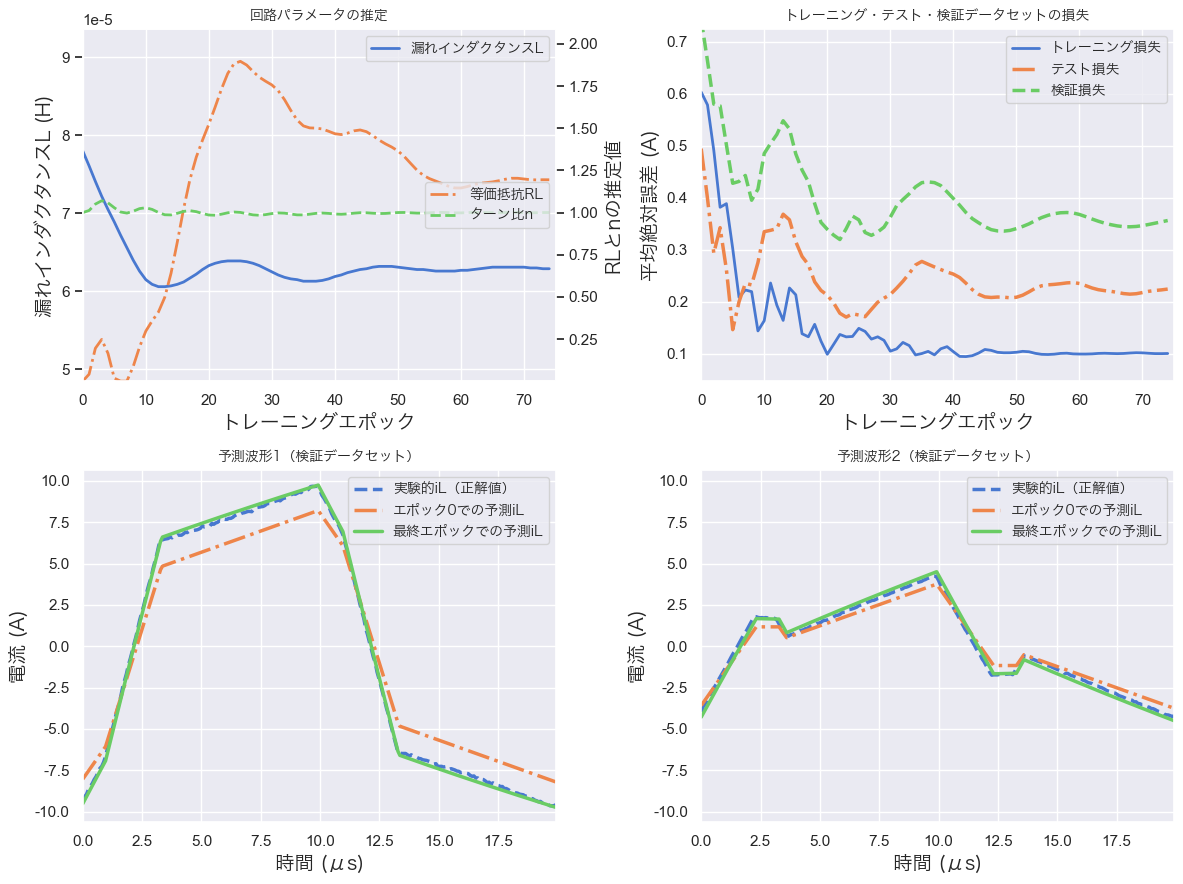

In [12]:
#################################################################################
# トレーニングプロセスの可視化
# 以下の3つのプロットを表示:
# (1) 回路パラメータの推定値の推移
# (2) 損失の軌跡（トレーニング、テスト、検証）
# (3) iL波形の予測（検証セットから2つのケース）

sns.set_theme(style="darkgrid")  # コントラストのためにダークグリッドの背景を使用

# 図とサブプロットを作成
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 9))
ax11_2 = ax11.twinx()  # 右側のy軸を作成

# 時間軸とインデックスの準備
t = np.array([i * dt for i in range(len(val_waveforms[0][0]))]) * 1e6  # μs単位
indices = np.array([i for i in range(len(loss_history))])

# 各プロットの範囲を設定
ax11.set_xlim(0, len(loss_history))
ax12.set_xlim(0, len(loss_history))
ax21.set_xlim(t.min(), t.max())
ax22.set_xlim(t.min(), t.max())

# ラベルとタイトルの設定
ax11.set_title(
    "回路パラメータの推定", fontsize=18, weight="bold", fontproperties=font_prop
)
ax12.set_title(
    "トレーニング・テスト・検証データセットの損失",
    fontsize=18,
    weight="bold",
    fontproperties=font_prop,
)
ax21.set_title(
    "予測波形1（検証データセット）",
    fontsize=18,
    weight="bold",
    fontproperties=font_prop,
)
ax22.set_title(
    "予測波形2（検証データセット）",
    fontsize=18,
    weight="bold",
    fontproperties=font_prop,
)

ax11.set_xlabel("トレーニングエポック", fontsize=14, fontproperties=font_prop)
ax11.set_ylabel("漏れインダクタンスL (H)", fontsize=14, fontproperties=font_prop)
ax11_2.set_ylabel("RLとnの推定値", fontsize=14, fontproperties=font_prop)
ax12.set_xlabel("トレーニングエポック", fontsize=14, fontproperties=font_prop)
ax12.set_ylabel("平均絶対誤差 (A)", fontsize=14, fontproperties=font_prop)
ax21.set_xlabel("時間 (μs)", fontsize=14, fontproperties=font_prop)
ax21.set_ylabel("電流 (A)", fontsize=14, fontproperties=font_prop)
ax22.set_xlabel("時間 (μs)", fontsize=14, fontproperties=font_prop)
ax22.set_ylabel("電流 (A)", fontsize=14, fontproperties=font_prop)

# y軸の範囲を設定
ax11.set_ylim(
    circuit_estimation_history[:, 0].min() * 0.8,
    circuit_estimation_history[:, 0].max() * 1.2,
)
ax11_2.set_ylim(
    circuit_estimation_history[:, 1].min() * 0.8,
    circuit_estimation_history[:, 1].max() * 1.1,
)
ax12.set_ylim(loss_history[:, 0].min() * 0.5, loss_history[:, 0].max() * 1.2)
ax21.set_ylim(-val_states.max() * 1.1, val_states.max() * 1.1)
ax22.set_ylim(-val_states.max() * 1.1, val_states.max() * 1.1)

# プロット1 - 回路パラメータの推定
ax11.plot(
    indices,
    circuit_estimation_history[:, 0],
    lw=2,
    label="漏れインダクタンスL",
    color=sns.color_palette("muted")[0],
    linestyle="-",
)
ax11_2.plot(
    indices,
    circuit_estimation_history[:, 1],
    lw=2,
    label="等価抵抗RL",
    color=sns.color_palette("muted")[1],
    linestyle="-.",
)
ax11_2.plot(
    indices,
    circuit_estimation_history[:, 2],
    lw=2,
    label="ターン比n",
    color=sns.color_palette("muted")[2],
    linestyle="--",
)

# プロット2 - 損失の軌跡
ax12.plot(
    indices,
    loss_history[:, 0],
    lw=2,
    label="トレーニング損失",
    color=sns.color_palette("muted")[0],
    linestyle="-",
)
ax12.plot(
    indices,
    loss_history[:, 1],
    lw=2.5,
    label="テスト損失",
    color=sns.color_palette("muted")[1],
    linestyle="-.",
)
ax12.plot(
    indices,
    loss_history[:, 2],
    lw=2.5,
    label="検証損失",
    color=sns.color_palette("muted")[2],
    linestyle="--",
)

# プロット3 - ケーススタディ1（検証波形）
ax21.plot(
    t,
    val_states[0, 1:, 0],
    lw=2.5,
    label="実験的iL（正解値）",
    color=sns.color_palette("muted")[0],
    linestyle="--",
)
ax21.plot(
    t,
    val_waveforms[0][0, :, 0],
    lw=2.5,
    label="エポック0での予測iL",
    color=sns.color_palette("muted")[1],
    linestyle="-.",
)
ax21.plot(
    t,
    val_waveforms[-1][0, :, 0],
    lw=2.5,
    label="最終エポックでの予測iL",
    color=sns.color_palette("muted")[2],
    linestyle="-",
)

# プロット4 - ケーススタディ2（検証波形）
ax22.plot(
    t,
    val_states[3, 1:, 0],
    lw=2.5,
    label="実験的iL（正解値）",
    color=sns.color_palette("muted")[0],
    linestyle="--",
)
ax22.plot(
    t,
    val_waveforms[0][1, :, 0],
    lw=2.5,
    label="エポック0での予測iL",
    color=sns.color_palette("muted")[1],
    linestyle="-.",
)
ax22.plot(
    t,
    val_waveforms[-1][1, :, 0],
    lw=2.5,
    label="最終エポックでの予測iL",
    color=sns.color_palette("muted")[2],
    linestyle="-",
)

# グリッドと凡例を追加
ax11.grid(True)
ax11_2.grid(False)
ax12.grid(True)
ax21.grid(True)
ax22.grid(True)
ax11.legend(loc="upper right", fontsize=12, prop=font_prop)
ax11_2.legend(loc="center right", fontsize=12, prop=font_prop)
ax12.legend(loc="upper right", fontsize=12, prop=font_prop)
ax21.legend(loc="upper right", fontsize=12, prop=font_prop)
ax22.legend(loc="upper right", fontsize=12, prop=font_prop)

# プロットを表示
plt.tight_layout()  # より良いフィットのためにレイアウトを調整
plt.show()

### 2.6 学習済みモデルの保存

In [13]:
# 最良のPANNチェックポイントの辞書を保存
torch.save(best_pann_states, "model_pann.pth")
print("学習済みモデルを 'model_pann.pth' として保存しました。")

学習済みモデルを 'model_pann.pth' として保存しました。
